<a href="https://colab.research.google.com/github/nepmontanez/sabanana/blob/main/googlecolab/sabanana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Python Libraries & Packages installation

In [1]:
# install tensorflow
!pip install tensorflow
!pip install tflite-model-maker

# install dependencies pkgs 
!pip install apache-beam[gcp]
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
!pip install sklearn

     |████████████████████████████████| 122kB 5.7MB/s 
     |████████████████████████████████| 81kB 4.4MB/s 
     |████████████████████████████████| 344.9MB 48kB/s 
     |████████████████████████████████| 849kB 42.4MB/s 
     |████████████████████████████████| 460kB 45.2MB/s 
     |████████████████████████████████| 1.1MB 27.3MB/s 
     |████████████████████████████████| 1.0MB 43.8MB/s 
     |████████████████████████████████| 11.9MB 45.0MB/s 
     |████████████████████████████████| 174kB 44.7MB/s 
     |████████████████████████████████| 102kB 12.2MB/s 
     |████████████████████████████████| 358kB 39.3MB/s 
     |████████████████████████████████| 36.7MB 92kB/s 
     |████████████████████████████████| 194kB 46.4MB/s 
  Created wheel for fire: filename=fire-0.3.1-py2.py3-none-any.whl size=111005 sha256=32f755069f1863a82c2bf9ad3a38e5c43f1eb95a646e840fc825363b549f1837
  Stored in directory: /root/.cache/pip/wheels/c1/61/df/768b03527bf006b546dce284eb4249b185669e65afc5fbb2ac
  Created wheel f

     |████████████████████████████████| 49.5MB 85kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


Training Phase

In [2]:
# import tensorflow modules 
import tensorflow as tf
assert tf.__version__.startswith('2')
from tensorflow_examples.lite.model_maker.core.data_util.image_dataloader import ImageClassifierDataLoader
from tensorflow_examples.lite.model_maker.core.task import image_classifier
from tensorflow_examples.lite.model_maker.core.task.model_spec import mobilenet_v2_spec
from tensorflow_examples.lite.model_maker.core.task.model_spec import ImageModelSpec
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# import necessary python modules
import numpy as np
import random
import matplotlib.pyplot as plt
import pathlib
import pathlib
from sklearn.model_selection import train_test_split

Get the images from the drive

In [4]:
from google.colab import drive

drive.mount('/content/drive')
data_dir = pathlib.Path('/content/drive/MyDrive/sabanana images/Training') 
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
105


Create a dataset

In [7]:
# Parameters Declaration
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

# normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(normalized_ds))
# first_image = image_batch[0]
# print(np.min(first_image), np.max(first_image)) 

Found 100 files belonging to 5 classes.
Using 80 files for training.
Found 100 files belonging to 5 classes.
Using 10 files for validation.
['Stage 1 [All Green]', 'Stage 2 [Green Turning Yellow]', 'Stage 3 [Greenish Yellow]', 'Stage 4 [Yellow with Green Tip]', 'Stage 5 [Yellow with Brown Flecks]']


Create tensorflow model

In [12]:

num_classes = 5
epochs = 16
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# model = Sequential([
#   layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
#   layers.Conv2D(32, 3, padding='same', activation='relu'),
#   layers.BatchNormalization(),
#   layers.MaxPooling2D(pool_size=(3, 3)),
#   layers.Dropout(0.25),
#   layers.Conv2D(64, 3, padding='same', activation='relu'),
#   layers.BatchNormalization(),
#   layers.Conv2D(64, 3, padding='same', activation='relu'),
#   layers.BatchNormalization(),
#   layers.MaxPooling2D(pool_size=(2, 2)),
#   layers.Dropout(0.25),
#   layers.Conv2D(128, 3, padding='same', activation='relu'),
#   layers.BatchNormalization(),
#   layers.Conv2D(128, 3, padding='same', activation='relu'),
#   layers.BatchNormalization(),
#   layers.MaxPooling2D(pool_size=(2, 2)),
#   layers.Dropout(0.25),
#   layers.Flatten(),
#   layers.Dense(1024, activation='relu'),
#   layers.Dense(num_classes),
#   layers.Activation("softmax")
# ])

# model.compile(optimizer='sgd',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

#model.summary()
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)


Epoch 1/16
3/3 [==============================] - 4s 2s/step - loss: 5.1236 - accuracy: 0.1250 - val_loss: 1.8925 - val_accuracy: 0.3000
Epoch 2/16
3/3 [==============================] - 4s 1s/step - loss: 1.6884 - accuracy: 0.2193 - val_loss: 1.6800 - val_accuracy: 0.2000
Epoch 3/16
3/3 [==============================] - 4s 1s/step - loss: 1.6227 - accuracy: 0.2292 - val_loss: 1.6142 - val_accuracy: 0.3000
Epoch 4/16
3/3 [==============================] - 4s 1s/step - loss: 1.5866 - accuracy: 0.2562 - val_loss: 1.5875 - val_accuracy: 0.1000
Epoch 5/16
3/3 [==============================] - 4s 1s/step - loss: 1.5502 - accuracy: 0.5104 - val_loss: 1.5445 - val_accuracy: 0.4000
Epoch 6/16
3/3 [==============================] - 4s 1s/step - loss: 1.4865 - accuracy: 0.5781 - val_loss: 1.4245 - val_accuracy: 0.7000
Epoch 7/16
3/3 [==============================] - 4s 1s/step - loss: 1.3697 - accuracy: 0.6844 - val_loss: 1.2670 - val_accuracy: 0.6000
Epoch 8/16
3/3 [=========================

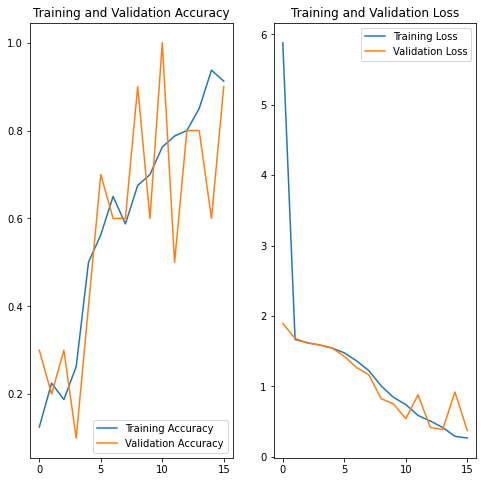

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Save the tensorflow model in drive

In [14]:
model.save('/content/drive/MyDrive/sabanana images/saved_model/final_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/MyDrive/sabanana images/saved_model/final_model/assets


Convert the created tensorflow model into tensorflow lite

In [15]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
tflite_models_dir = pathlib.Path('/content/drive/MyDrive/sabanana images/saved_model/final_model')
tflite_models_dir.mkdir(exist_ok=True, parents=True)
tflite_model_file = tflite_models_dir/"saved_model.tflite"
tflite_model_file.write_bytes(tflite_model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()
tflite_model_quant_file = tflite_models_dir/"model.tflite"
tflite_model_quant_file.write_bytes(tflite_quant_model)

INFO:tensorflow:Assets written to: /tmp/tmp1cq4s7k8/assets
INFO:tensorflow:Assets written to: /tmp/tmpmjy_iz9j/assets


INFO:tensorflow:Assets written to: /tmp/tmpmjy_iz9j/assets


6456880